In [1]:
import collections, math, os, sys
sys.path.insert(0, '../../../../FISH-annotation/fishanno')
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation
from sklearn.neighbors import KDTree
import util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats

# Recall vs. SNR
Recall vs. SNR. Each marker represents one SNR bin.

In [2]:
snr_list = [3,5,7,9,11]
clustering_params = ['AffinityPropagation', -350]
correctness_threshold = 4
declumping_params = ['KMeans', 2]
height = 300
cwd = os.getcwd()

## spot size = 0.5
original and inverted images

In [3]:
json_paths = [cwd + '/datasets/anno/sz_0.5_snr_1_3_5_7_9_11.json',
              cwd + '/datasets/anno/sz_0.5_snr_1_3_5_7_9_11_inv.json']

num_spots_detected_list = [0]*len(snr_list)
num_spots_total_list = [0]*len(snr_list)
detection_lists = []

# for each file
for json_path in json_paths:
    detection_list = []
    # for each image
    for index in range(len(snr_list)):
        snr = snr_list[index]

        if(json_path == json_paths[0]):
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_0.5_spot_img.png'
            img_path = cwd + '/datasets/spot_images/og/' + img_name
            csv_path = cwd + '/datasets/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_0.5_coord_snr_list.csv'
        else:
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_0.5_spot_img_inv.png'
            img_path = cwd + '/datasets/spot_images/inv/' + img_name
            csv_path = cwd + '/datasets/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_0.5_coord_snr_list.csv'
        
        """ Get cluster centroids """
        qa = QuantiusAnnotation(json_path, img_name)
        anno_all = qa.df()
        sa = SpotAnnotationAnalysis(qa)

        clusters = sa.get_clusters(anno_all, clustering_params)
        cluster_size_threshold = util.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
        clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        result_clusters = nonclumpy_clusters
        for i in range(len(clumpy_clusters.index)):
            subclusters = util.declump(clumpy_clusters, i, declumping_params)
            result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

        """ Count up num_spots_detected, num_spots_total at each SNR """
        result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
        result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')
        
        ref_df = pd.read_csv(csv_path)
        ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
        ref_points_snr = ref_df.loc[:, ['snr']].as_matrix()

        # for each bin
        for bin_midpoint in snr_list:
            num_total = 0
            num_detected = 0

            # for each spot in the image
            for ref_point, ref_snr in zip(ref_points, ref_points_snr):
                ref_snr = ref_snr[0]

                # if the spot's is in the SNR bin
                if (ref_snr > bin_midpoint-1) and (ref_snr <= bin_midpoint+1):
                    num_total += 1
                    dist, ind = result_kdt.query([[ref_point[0], height-ref_point[1]]], k=1)
                    if dist[0][0] <= correctness_threshold:
                        num_detected += 1
            num_spots_total_list[index] += num_total    
            num_spots_detected_list[index] += num_detected

    detection_list = [d/t for d, t in zip(num_spots_detected_list, num_spots_total_list)]
    detection_lists.append(detection_list)
    
detection_lists_0_5 = detection_lists


../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a

../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a

In [4]:
json_paths = [cwd + '/datasets/anno/sz_1_snr_1_3_5_7_9_11.json',
              cwd + '/datasets/anno/sz_1_snr_1_3_5_7_9_11_inv.json']

num_spots_detected_list = [0]*len(snr_list)
num_spots_total_list = [0]*len(snr_list)
detection_lists = []

# for each file
for json_path in json_paths:
    detection_list = []
    # for each image
    for index in range(len(snr_list)):
        snr = snr_list[index]
        
        if(json_path == json_paths[0]):
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_1_spot_img.png'
            img_path = cwd + '/datasets/spot_images/og/' + img_name
            csv_path = cwd + '/datasets/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_1_coord_snr_list.csv'
        else:
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_1_spot_img_inv.png'
            img_path = cwd + '/datasets/spot_images/inv/' + img_name
            csv_path = cwd + '/datasets/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_1_coord_snr_list.csv'
        
        """ Get cluster centroids """
        qa = QuantiusAnnotation(json_path, img_name)
        anno_all = qa.df()
        sa = SpotAnnotationAnalysis(qa)

        clusters = sa.get_clusters(anno_all, clustering_params)
        cluster_size_threshold = util.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
        clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        result_clusters = nonclumpy_clusters
        for i in range(len(clumpy_clusters.index)):
            subclusters = util.declump(clumpy_clusters, i, declumping_params)
            result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

        """ Count up num_spots_detected, num_spots_total at each SNR """
        result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
        result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')

        ref_df = pd.read_csv(csv_path)
        ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
        ref_points_snr = ref_df.loc[:, ['snr']].as_matrix()

        # for each bin
        for bin_midpoint in snr_list:
            num_total = 0
            num_detected = 0

            # for each spot in the image
            for ref_point, ref_snr in zip(ref_points, ref_points_snr):
                ref_snr = ref_snr[0]

                # if the spot's is in the SNR bin
                if (ref_snr > bin_midpoint-1) and (ref_snr <= bin_midpoint+1):
                    num_total += 1
                    dist, ind = result_kdt.query([[ref_point[0], height-ref_point[1]]], k=1)
                    if dist[0][0] <= correctness_threshold:
                        num_detected += 1
            num_spots_total_list[index] += num_total    
            num_spots_detected_list[index] += num_detected

    detection_list = [d/t for d, t in zip(num_spots_detected_list, num_spots_total_list)]
    detection_lists.append(detection_list)

detection_lists_1_0 = detection_lists


../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a

../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a

## spot size = 1.75
original and inverted images

In [5]:
json_paths_1 = [cwd + '/datasets/anno/sz_1.75_snr_1_3.json',
               cwd + '/datasets/anno/sz_1.75_snr_1_3_inv.json']

num_spots_detected_list_1 = [0]
num_spots_total_list_1 = [0]
detection_lists_1 = []
snr_list = [3]

# for each file
for json_path in json_paths_1:
    detection_list = []
    # for each image
    for index in range(len(snr_list)):
        snr = snr_list[index]

        if(json_path == json_paths_1[0]):
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_img.png'
            img_path = cwd + '/datasets/spot_images/og/' + img_name
            csv_path = cwd + '/datasets/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_coord_snr_list.csv'
        else:
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_img_inv.png'
            img_path = cwd + '/datasets/spot_images/inv/' + img_name
            csv_path = cwd + '/datasets/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_coord_snr_list.csv'
        
        """ Get cluster centroids """
        qa = QuantiusAnnotation(json_path, img_name)
        anno_all = qa.df()
        sa = SpotAnnotationAnalysis(qa)

        clusters = sa.get_clusters(anno_all, clustering_params)
        cluster_size_threshold = util.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
        clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        result_clusters = nonclumpy_clusters
        for i in range(len(clumpy_clusters.index)):
            subclusters = util.declump(clumpy_clusters, i, declumping_params)
            result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

        """ Count up num_spots_detected, num_spots_total at each SNR """
        result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
        result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')

        ref_df = pd.read_csv(csv_path)
        ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
        ref_points_snr = ref_df.loc[:, ['snr']].as_matrix()

        # for each bin
        for bin_midpoint in snr_list:
            num_total = 0
            num_detected = 0

            # for each spot in the image
            for ref_point, ref_snr in zip(ref_points, ref_points_snr):
                ref_snr = ref_snr[0]

                # if the spot's is in the SNR bin
                if (ref_snr > bin_midpoint-1) and (ref_snr <= bin_midpoint+1):
                    num_total += 1
                    dist, ind = result_kdt.query([[ref_point[0], height-ref_point[1]]], k=1)
                    if dist[0][0] <= correctness_threshold:
                        num_detected += 1
            num_spots_total_list_1[index] += num_total    
            num_spots_detected_list_1[index] += num_detected

    detection_list = [d/t for d, t in zip(num_spots_detected_list_1, num_spots_total_list_1)]
    detection_lists_1.append(detection_list)


../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:46: FutureWarning: Method .as_matrix will be removed in a

In [7]:
json_paths_2 = [cwd + '/datasets/anno/sz_1.75_snr_5_7_9_11.json', 
               cwd + '/datasets/anno/sz_1.75_snr_5_7_9_11_inv.json']

num_spots_detected_list_2 = [0]*len(snr_list)
num_spots_total_list_2 = [0]*len(snr_list)

detection_lists_2 = []
snr_list = [5, 7, 9, 11]    

# for each file
for json_path in json_paths_2:
    detection_list = []
    # for each image
    for index in range(len(snr_list)):
        
        snr = snr_list[index]

        if(json_path == json_paths_2[0]):
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_img.png'
            img_path = cwd + '/datasets/spot_images/og/' + img_name
            csv_path = cwd + '/datasets/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_coord_snr_list.csv'
        else:
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_img_inv.png'
            img_path = cwd + '/datasets/spot_images/inv/' + img_name
            csv_path = cwd + '/datasets/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_coord_snr_list.csv'
        
        """ Get cluster centroids """
        qa = QuantiusAnnotation(json_path, img_name)
        anno_all = qa.df()
        sa = SpotAnnotationAnalysis(qa)

        clusters = sa.get_clusters(anno_all, clustering_params)
        cluster_size_threshold = util.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
        clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        result_clusters = nonclumpy_clusters
        for i in range(len(clumpy_clusters.index)):
            subclusters = util.declump(clumpy_clusters, i, declumping_params)
            result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

        """ Count up num_spots_detected, num_spots_total at each SNR """
        result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
        result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')

        ref_df = pd.read_csv(csv_path)
        ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
        ref_points_snr = ref_df.loc[:, ['snr']].as_matrix()

        # for each bin
        for bin_midpoint in snr_list:
            num_total = 0
            num_detected = 0

            # for each spot in the image
            for ref_point, ref_snr in zip(ref_points, ref_points_snr):
                ref_snr = ref_snr[0]

                # if the spot's snr is in the SNR bin
                if (ref_snr > bin_midpoint-1) and (ref_snr <= bin_midpoint+1):
                    num_total += 1
                    dist, ind = result_kdt.query([[ref_point[0], height-ref_point[1]]], k=1)
                    if dist[0][0] <= correctness_threshold:
                        num_detected += 1
            num_spots_total_list_2[index] += num_total    
            num_spots_detected_list_2[index] += num_detected

    detection_list = [d/t for d, t in zip(num_spots_detected_list_2, num_spots_total_list_2)]
    detection_lists_2.append(detection_list)


../../../../FISH-annotation/fishanno/util.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())           # get the list of occasions
../../../../FISH-annotation/fishanno/util.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:43: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:47: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:48: FutureWarning: Method .as_matrix will be removed in a

In [8]:
detection_list_og = detection_lists_1[0] + detection_lists_2[0]
detection_list_inv = detection_lists_1[1] + detection_lists_2[1]
detection_lists = [detection_list_og, detection_list_inv]
detection_lists_1_75 = detection_lists
snr_list = [3,5,7,9,11]

In [9]:
recall_og = detection_lists_0_5[0] + detection_lists_1_0[0] + detection_lists_1_75[0]
recall_inv = detection_lists_0_5[1] + detection_lists_1_0[1] + detection_lists_1_75[1]

slope, intercept, r_value, p_value, std_err = stats.linregress(recall_og, recall_inv)
line = [slope * x + intercept for x in recall_og]

In [10]:
if not os.path.exists('data_2'):
    os.mkdir('data_2')

In [11]:
np.savetxt('./data_2/recall_og.csv', recall_og, delimiter=',')
np.savetxt('./data_2/recall_inv.csv', recall_inv, delimiter=',')

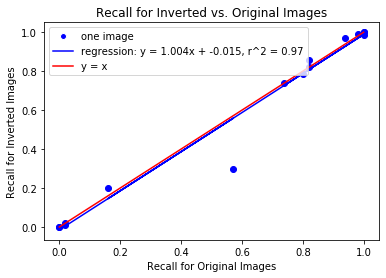

In [12]:
recall_og = np.genfromtxt('./data_2/recall_og.csv')
recall_inv = np.genfromtxt('./data_2/recall_inv.csv')

plt.figure()
plt.plot(recall_og,recall_inv,'o', recall_og, line, c='b')
plt.plot([0,1], [0,1], c='r')
plt.title('Recall for Inverted vs. Original Images')
plt.xlabel('Recall for Original Images')
plt.ylabel('Recall for Inverted Images')

e1 = Line2D([0],[0], marker='o', color='w', markerfacecolor='b', label='one image')
e2 = Line2D([0],[0], color='b', label='regression: y = %sx + %s, r^2 = %s' % (round(slope,3), round(intercept,3), round((r_value*r_value),3)))
e3 = Line2D([0],[0], color='r', label='y = x')
plt.legend(handles=[e1, e2, e3], loc='upper left')
plt.savefig("recall_inv_vs_orig.pdf", transparent=True, bbox_inches="tight")

plt.show()